<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/CPRAVG_SARIMAX_Dec2Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pmdarima

     |████████████████████████████████| 1.5 MB 27.8 MB/s 
     |████████████████████████████████| 9.5 MB 29.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import pmdarima as pm

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
path = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/Aug_2020_Jan_2021.xlsx?raw=true"
df = pd.read_excel(path)
df = df.dropna()
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.index = date_time
df.head()

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,DRAFT,ETH
Date Time,,,,,,,,,
2020-08-01 06:00:00,0.552571,15.46483,3.331099,27302.169922,851.987457,657.617325,0.477837,-4.472712,79.803261
2020-08-01 06:10:00,0.552694,15.90670,3.463089,27307.130859,851.831329,656.870697,0.470079,-4.463849,79.236847
2020-08-01 06:20:00,0.552795,15.91155,3.440511,27312.089844,852.074249,657.570480,0.475148,-4.467927,79.277817
2020-08-01 06:30:00,0.552883,15.92818,3.462565,27317.050781,852.018509,657.838837,0.478610,-4.467236,79.265282
2020-08-01 06:40:00,0.552948,15.96785,3.537904,27322.019531,851.803070,656.919052,0.473484,-4.440002,79.184639


In [ ]:
number_of_days = (df.shape[0]//144)+1 #// for integer division
number_of_extra_rows = df.shape[0]%144
df_days = df.rolling(144).mean().dropna()
df_days = df_days.iloc[::144,:]
df_extra = df[86*144:df.shape[0]].mean()
df_days = df_days.append(df_extra,ignore_index=True)
df_days

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,DRAFT,ETH
0,0.551781,16.736688,3.527453,27423.625597,851.213032,656.232086,0.474724,-4.456138,78.610182
1,0.552217,16.426507,3.357397,27392.391832,851.974807,658.743587,0.475176,-4.428111,79.124997
2,0.554570,16.520457,3.222832,27370.677151,852.021264,657.712425,0.475564,-4.406658,79.056077
3,0.556584,15.607427,3.371049,27250.233114,851.937782,658.086404,0.475312,-4.407059,79.672467
4,0.558787,15.285906,3.274519,27313.142036,851.996744,656.613482,0.474936,-4.407986,79.944559
...,...,...,...,...,...,...,...,...,...
176,0.371157,24.818784,4.324998,0.000000,851.272438,725.036737,0.481156,-4.684950,68.890947
177,0.428648,25.228275,4.220903,18221.388206,827.153755,667.686405,0.482934,-4.805542,67.326352
178,0.455254,25.097550,4.390245,27116.935384,836.400483,648.666331,0.484263,-4.737650,67.496441
179,0.463183,25.173927,4.354998,27401.301826,844.673694,648.582769,0.484465,-4.906785,67.686970


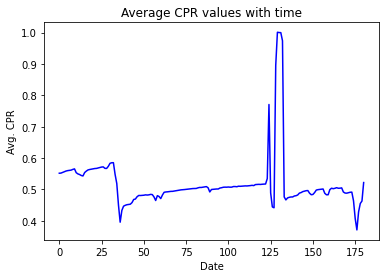

In [ ]:
df = df_days
#Plotting the CPRAVG data

import matplotlib.pyplot as plt
plt.title('Average CPR values with time')
plt.xlabel('Date')
plt.ylabel('Avg. CPR')
plt.plot(df['CPRAVG'],color = 'blue')

In [ ]:
#Printing list of columns:
cols = list(df)[0:df.shape[1]]
print(cols)

['CPRAVG', 'PROP ', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['CPRAVG'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.276757
p-value                   0.015950
# lags used               9.000000
# observations          171.000000
critical value (1%)      -3.469181
critical value (5%)      -2.878595
critical value (10%)     -2.575863
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


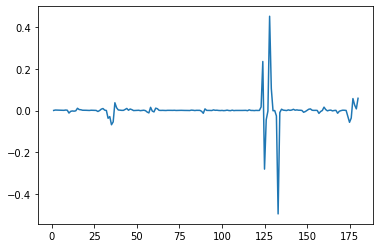

In [ ]:
#Differencing the data.
diff_df = df['CPRAVG'].diff().dropna()
plt.plot(diff_df)

In [ ]:
adf_test(diff_df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.160007
p-value                   0.000011
# lags used              13.000000
# observations          166.000000
critical value (1%)      -3.470370
critical value (5%)      -2.879114
critical value (10%)     -2.576139
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


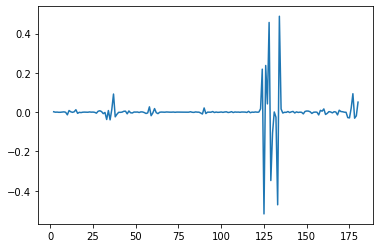

In [ ]:
#Second Differencing the data.
diff_df2 = diff_df.diff().dropna()
plt.plot(diff_df2)

In [ ]:
adf_test(diff_df2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.877825e+00
p-value                 4.791120e-12
# lags used             1.100000e+01
# observations          1.670000e+02
critical value (1%)    -3.470126e+00
critical value (5%)    -2.879008e+00
critical value (10%)   -2.576083e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


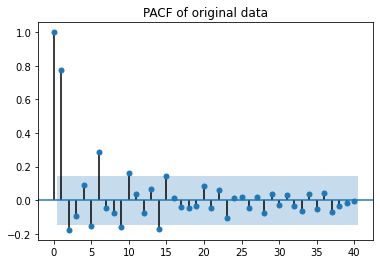

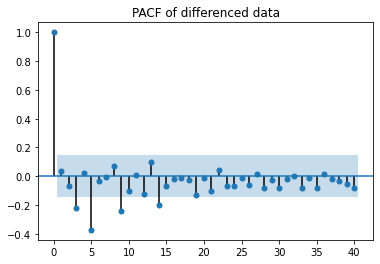

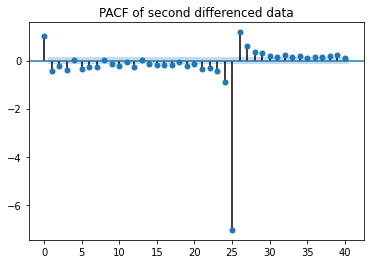

In [ ]:
#PACF
plot_pacf(df['CPRAVG'],lags = 40)
plt.title('PACF of original data')
plt.show()

plot_pacf(diff_df,lags = 40)
plt.title('PACF of differenced data')
plt.show()

plot_pacf(diff_df2,lags = 40)
plt.title('PACF of second differenced data')
plt.show()

In [ ]:
auto_arima(df['CPRAVG'],max_p=10,max_d=10,max_q=10,seasonal=False,m=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  181
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 276.373
Date:                Tue, 17 Aug 2021   AIC                           -540.747
Time:                        04:31:32   BIC                           -521.556
Sample:                             0   HQIC                          -532.966
                                - 181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3815      0.073      5.211      0.000       0.238       0.525
ar.L1         -0.2777      0.047     -5.915      0.000      -0.370      -0.186
ar.L2          0.5430      0.093      5.824      0.000       0.360       0.726
ma.L1          1.2615      0.037     34.078      0.000       1.189       1.334
ma.L2          0.4490      0.034     13.044      0.000       0.382       0.516
sigma2         0.0027      0.000     26.745      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5019.96
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              25.52   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Splitting the data:
split_length = 0.7
train_df = df[0:int(split_length*df.shape[0])]
val_df = df[int(split_length*df.shape[0]):df.shape[0]]
train_df.head()

,CPRAVG,PROP,BUT,FLW,COT,TEMP,PRESS,DRAFT,ETH
0,0.551781,16.736688,3.527453,27423.625597,851.213032,656.232086,0.474724,-4.456138,78.610182
1,0.552217,16.426507,3.357397,27392.391832,851.974807,658.743587,0.475176,-4.428111,79.124997
2,0.554570,16.520457,3.222832,27370.677151,852.021264,657.712425,0.475564,-4.406658,79.056077
3,0.556584,15.607427,3.371049,27250.233114,851.937782,658.086404,0.475312,-4.407059,79.672467
4,0.558787,15.285906,3.274519,27313.142036,851.996744,656.613482,0.474936,-4.407986,79.944559


In [ ]:
# auto_arima(train_df['CPRAVG'],max_p=10,max_d=10,max_q=10,seasonal=False,m=1).summary()

In [ ]:
model = SARIMAX(train_df['CPRAVG'],exog = train_df[['BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']],order=(2,0,2),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CPRAVG   No. Observations:                  126
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 324.259
Date:                Tue, 17 Aug 2021   AIC                           -624.519
Time:                        04:31:33   BIC                           -590.483
Sample:                             0   HQIC                          -610.691
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BUT           -0.0207      0.008     -2.500      0.012      -0.037      -0.004
FLW         2.856e-06   6.79e-07      4.208      0.000    1.53e-06    4.19e-06
COT        -9.746e-06      0.000     -0.073      0.942      -0.000       0.000
TEMP           0.0002      0.000      0.745      0.457      -0.000       0.001
PRESS         -0.3111      0.406     -0.765      0.444      -1.108       0.485
DRAFT         -0.0588      0.011     -5.596      0.000      -0.079      -0.038
ETH            0.0038      0.001      2.820      0.005       0.001       0.007
ar.L1          0.7388      0.732      1.009      0.313      -0.696       2.174
ar.L2          0.0968      0.533      0.182      0.856      -0.948       1.142
ma.L1          0.1235      0.721      0.171      0.864      -1.290       1.537
ma.L2         -0.3041      0.219     -1.385      0.166      -0.734       0.126
sigma2         0.0004   6.13e-05      5.763      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               380.29
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -1.83
Prob(H) (two-sided):                  0.35   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start=len(train_df)
end=df.shape[0]-1
exog_forecast= val_df[['BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast,dynamic = True).rename('SARIMAX(1,1,4) Predictions')

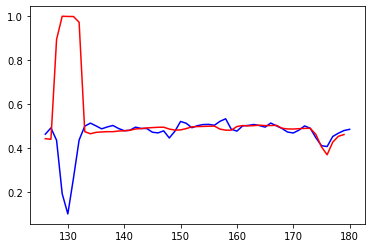

In [ ]:
plt.plot(predictions, color = 'blue')
plt.plot(df['CPRAVG'][start:end], color = 'red')